# BloomTech Data Science - Topic Modeling
## Unit 4.1.4 Project*

Michael Luo

2023/02/25

![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

Apply Topic Modeling to Analyze a corpus of Amazon reviews

- Load in the Amazon Review dataset
- Clean the dataset 
- Vectorize the dataset 
- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end

In [ ]:
!pip install pyLDAvis==3.3.1
!pip install pandarallel==1.4.8
!python -m spacy download en_core_web_lg

## Restart runtime!

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy

import pyLDAvis
import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


----
### Load the Amazon Review corpus 
This dataset is located in the Sprint 1 Module 1 `/data` directory. 

If the provided relative path doesn't work for you, then you'll have to provide the file path so pandas can read in the file.

In [2]:
# A "brute force" way to get the Amazon reviews dataset; just clone the Sprint 1 repo!
# Overkill, but it does the job!
!git clone https://github.com/michael-s-luo/DS4.1_Natural-Language-Processing.git

Cloning into 'DS4.1_Natural-Language-Processing'...
remote: Enumerating objects: 448, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (432/432), done.
remote: Total 448 (delta 32), reused 419 (delta 16), pack-reused 0
Receiving objects: 100% (448/448), 20.78 MiB | 36.88 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
!unzip '/content/DS4.1_Natural-Language-Processing/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip'

Archive:  /content/DS4.1_Natural-Language-Processing/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


In [2]:
data_path = "/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(data_path)

In [3]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


----

### Clean data

- Create a function called `clean_data` that uses regex expressions to clean your data in preparation for the vectorizer. 

- Save the clean text data to a column in your dataframe named `clean_text`

- Feel free to re-use old code that you have written in previous modules  

In [4]:
df.shape

(28332, 24)

In [5]:
df['reviews.text'][8505]

'Have had zero issues with longevity or voltage. As good as the major brand batteries'

In [6]:
def clean_data(text):
  """
  Cleans data to remove unwanted characters and punctuation.
  """
  text = re.sub(r"[^a-zA-Z ]", "", text)

  return text.strip().lower()
 


In [7]:
# create a clean_text column by applying  clean_data to your text
df['clean_text'] = df['reviews.text'].apply(clean_data)

------

## Determine number of topics

We are going to run an experiment to determine how many topics exists within the `primaryCategories` of `Electronics`. This is the largest primary category containing nearly 14K documents, so we should have plenty of data. 

Just as we did in the guided project, we'll be running a gridseach over the number of topics and scoring each model using the Coherence metric to determine which number of topics we should use. 


In [8]:
# create a mask for docs that are in the Electronics primaryCategories - save result to `electronics_mask`
electronics_mask = df['primaryCategories'] == "Electronics"

# use mask to select all the documents in the Electronics primaryCategories - save result to `df_electronics`
df_electronics = df[electronics_mask]

In [9]:
df_electronics.shape

(13995, 25)

------
### Tokenize your documents 

Remember that you'll need to use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class from the Gensim library. So definitely check out the docs to learn more about this tool. There is an example on how to do this in the guided project.

But before we can use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class, we must first tokenize our articles. 



In [10]:
# load in the spaCy language model
nlp = spacy.load("en_core_web_lg")

In [11]:
%%time
# create our tokens in the form of lemmas 
df_electronics['lemmas'] = df_electronics['clean_text'].apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (len(token.lemma_) > 1)])

CPU times: user 1min 58s, sys: 534 ms, total: 1min 59s
Wall time: 2min 8s


### Use the corpora class to prep your data for LDA

You'll need to create the same `id2word` and `corpus` objects that we created in the guided projects. So be sure to reference the guided project notebook if you need to. 

In [13]:
# Create lemma dictionary using Dictionary - save result to `id2word`
# Dictionary where keys=id, values=set of lemmas for our entire training set
id2word = corpora.Dictionary(df_electronics['lemmas'])

# Create Term Document Frequency list - save result to `corpus`

corpus = [id2word.doc2bow(doc_lemma) for doc_lemma in df_electronics['lemmas']]

## Gridsearch the number of topics 

Just as we did in the guided project, we're going to run a `for` loop over a range of possible number of topics and then plot the `coherence_values` to determine which number of topics leads to the most sensible grouping of documents. 

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=2, limit=16, step=2)

CPU times: user 3min, sys: 13 s, total: 3min 13s
Wall time: 4min 52s


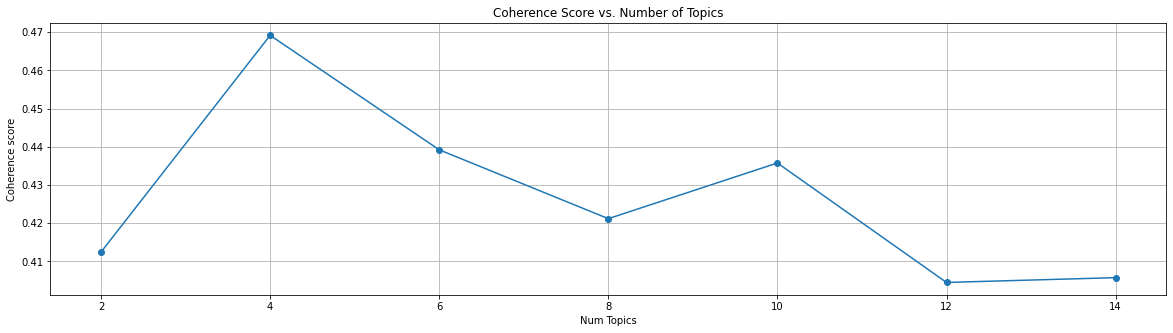

In [16]:
start=2; limit=16;  step=2;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=3, limit=6, step=1)

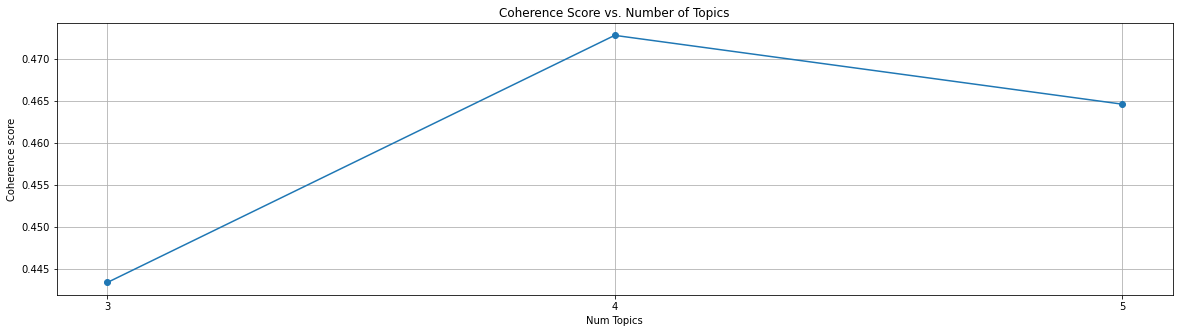

In [24]:
start=3; limit=6;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [25]:
# np.argmax() -> get index of largest coherence value from coherence_values -> save to `max_cohereance_val_index`

# `max_coherence_val_index` to index model_list for the corresponding model -> save to `lda_trained_model`
max_coherence_val_index = np.argmax(coherence_values)

lda_trained_model = model_list[max_coherence_val_index]
lda_trained_model


## Use pyLDAvis to visualize your topics 

Take a look at the topic bubbles and bar chart for the terms on the right hand side.  

- Describe the topic bubbles. 
- Do they overlap or not? 
- What does it mean when they overlap? 
- What does it mean when they don't overlap?
- Are the terms in each topic distinct from the topics in the other topic bubbles?


In [27]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00


In [37]:
# plot your topics here -- using pyLDAvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.062717  0.003748       1        1  32.511639
0      0.236445  0.063174       2        1  23.555763
2     -0.091511 -0.250291       3        1  22.772160
1     -0.207651  0.183370       4        1  21.160438, topic_info=         Term         Freq        Total Category  logprob  loglift
6        love  4305.000000  4305.000000  Default  30.0000  30.0000
872      read  1900.000000  1900.000000  Default  29.0000  29.0000
140       old  1904.000000  1904.000000  Default  28.0000  28.0000
430      book  1655.000000  1655.000000  Default  27.0000  27.0000
99        not  2604.000000  2604.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1064       hd   266.114879   858.420725   Topic4  -5.0184   0.3819
300      find   221.128738   502.180355   Topic4  -5.2036   0.7328
2       great   298.710868  4649.409528   Topic4  -4.9029  -1.1920
579   feature   217.835990   662.898670   Topic4  -5.2186   0.4402
317      need   211.007508  1036.433310   Topic4  -5.2505  -0.0386

[266 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1089      2  0.991539            
1136      2  0.049067  absolutely
1136      3  0.947001  absolutely
2412      2  0.995507          ad
1655      1  0.990882       adult
...     ...       ...         ...
1026      2  0.031430        year
1026      3  0.968543        year
1361      3  0.996241       young
1522      1  0.995531     youtube
1499      3  0.996681          yr

[336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

## Create a Topic id/name dictionary 

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool. 

We'll use a function to map the the viz tool index ordering with the train LDA model ordering. 

In [42]:
# create a dictionary 
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`

vis_topic_name_dict = {
    1: "Table / Video",
    2: "Issues",
    3: "Family / Gifts",
    4: "Reading Devices",
}


In [40]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids accoridng to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

Create a topic id/name look up dict 
that is aligned with the index ordering of the trained LDA model

In [43]:
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

In [44]:
topic_name_dict

{3: 'Table / Video', 0: 'Issues', 2: 'Family / Gifts', 1: 'Reading Devices'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [45]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get the index for the topic that had the highest probability, for the current document 
        max_topic_prob_ind = np.argmax(topic_probs)
        # get the corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store the most probable topic id for the current document
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [46]:
# use get_topic_ids_for_docs to get the topic id for each doc in the corpus - save result to `doc_topic_ids`
doc_topic_ids = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a new feature in df_electronics called topic_id using `doc_topic_ids`
df_electronics['topic_id'] = doc_topic_ids

# iterate through topic_id and use the lookup dict `topic_name_dict` to assign each document a topic name
# save results to a new feature in df_electronics called `new_topic_name`
df_electronics['new_topic_name'] = df_electronics['topic_id'].map(topic_name_dict)


## Congratulations! You have created new topic names for your documents. 

In [51]:
cols = ["reviews.text", "new_topic_name", "topic_id"]
df_electronics[cols].head(15)

,reviews.text,new_topic_name,topic_id
8343,Great case to keep everything in its place! My...,Family / Gifts,2
8344,After discarding and getting rid of broken cd ...,Issues,0
8345,"A few dollars more, but I am boycotting amazon",Table / Video,3
8346,My initial impression of this was very good. T...,Reading Devices,1
8347,Pros: Standard Echo. Cons: Older generation Ec...,Issues,0
8348,"Pros: Got it for under 50, much impressive sou...",Table / Video,3
8349,Pros: I love the Alexa series so when this one...,Issues,0
8350,"ASIDE FROM THE FACT THAT THE SCREEN IS SMALL, ...",Issues,0
8351,"I wasn't sure I even wanted this item, but cau...",Issues,0
8352,Pros: Works good like Alexia Cons: setting it ...,Table / Video,3


## Topic Modeling References



- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures